In [2]:
from google.colab import files
uploaded = files.upload()


Saving email.csv to email.csv


# Importing necessary libraries

In [53]:
import warnings
warnings.filterwarnings('ignore')

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk

from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier

# Reading dataset

In [55]:
df = pd.read_csv('email.csv')

# Data Exploration

In [56]:
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [57]:
df.tail()

,Category,Message
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...
5571,ham,Rofl. Its true to its name
5572,"{""mode"":""full""",isActive:false}


In [58]:
df.shape


(5573, 2)

In [59]:
df.columns

Index(['Category', 'Message'], dtype='object')

In [60]:
df.duplicated().sum()

np.int64(415)

In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5573 entries, 0 to 5572
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5573 non-null   object
 1   Message   5573 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [62]:
df.describe()

,Category,Message
count,5573,5573
unique,3,5158
top,ham,"Sorry, I'll call later"
freq,4825,30


In [63]:
df.nunique()

,0
Category,3
Message,5158


In [64]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [65]:
df.drop_duplicates(inplace=True)
df.dropna(inplace=True)

In [66]:
df.Category.value_counts()

,count
Category,
ham,4516
spam,641
"{""mode"":""full""",1


In [67]:
[df.Category == '{"mode":"full"']

[0       False
 1       False
 2       False
 3       False
 4       False
         ...  
 5568    False
 5569    False
 5570    False
 5571    False
 5572     True
 Name: Category, Length: 5158, dtype: bool]

In [69]:
if 5572 in df.index:
    df.drop(index=5572, inplace=True)

print("Dataset Shape:", df.shape)
print("Category Distribution:\n", df['Category'].value_counts())

Dataset Shape: (5157, 2)
Category Distribution:
 Category
ham     4516
spam     641
Name: count, dtype: int64


# Data Visualization


Let's visualize the distribution of 'ham' and 'spam' emails in the dataset to understand the class imbalance.

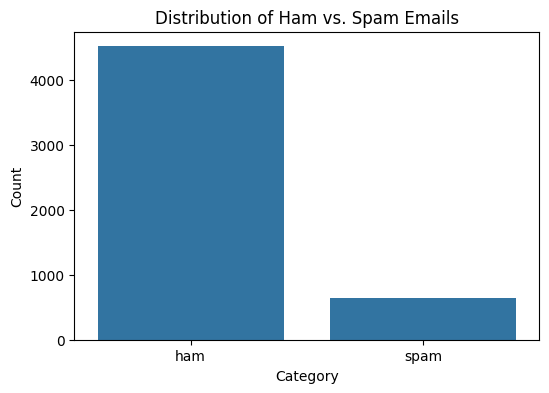

In [70]:
plt.figure(figsize=(6, 4))
sns.countplot(x='Category', data=df)
plt.title('Distribution of Ham vs. Spam Emails')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()

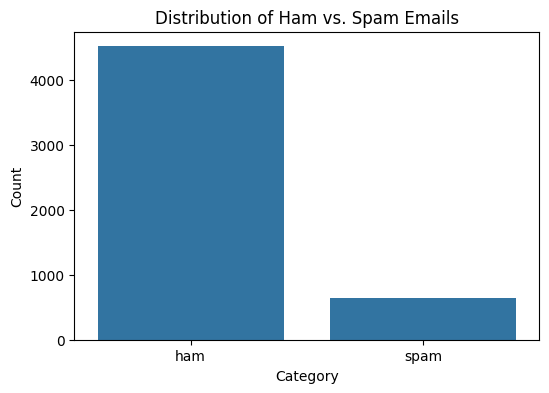

In [71]:
plt.figure(figsize=(6, 4))
sns.countplot(x='Category', data=df)
plt.title('Distribution of Ham vs. Spam Emails')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()

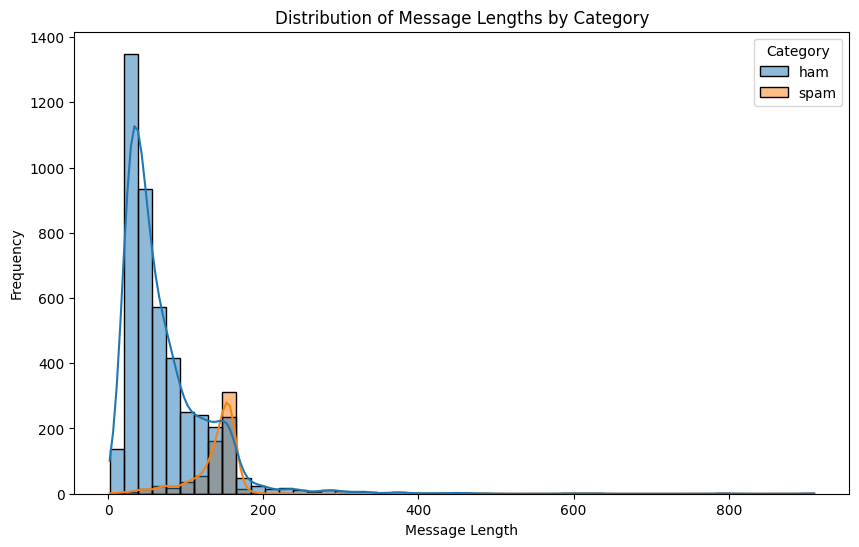

In [72]:
df['message_length'] = df['Message'].apply(len)

plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='message_length', hue='Category', kde=True, bins=50)
plt.title('Distribution of Message Lengths by Category')
plt.xlabel('Message Length')
plt.ylabel('Frequency')
plt.show()

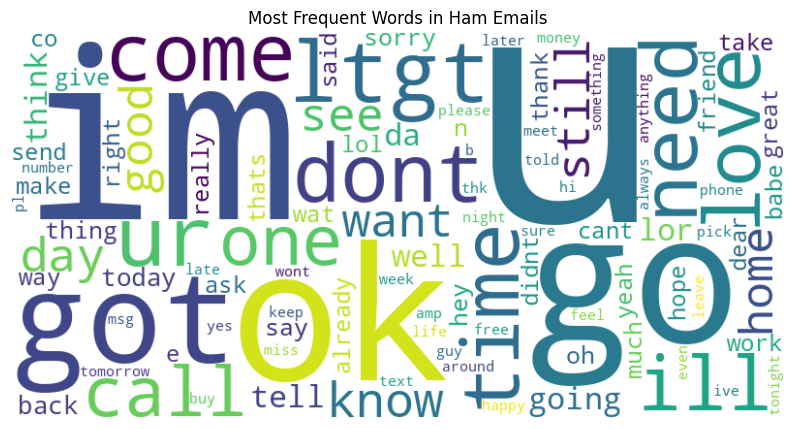

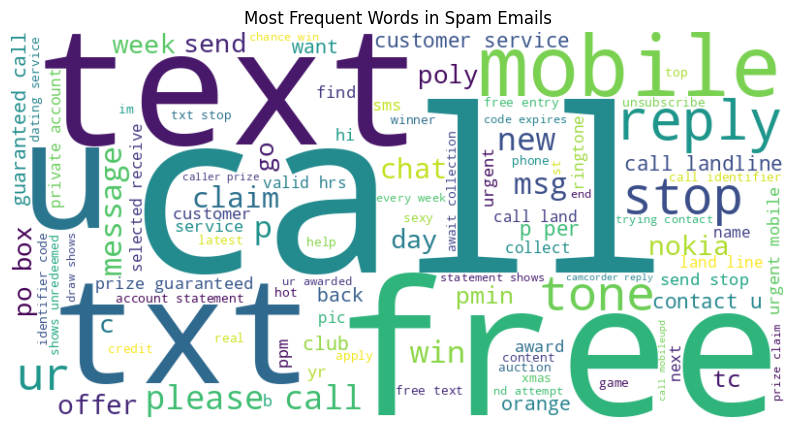

In [75]:
from wordcloud import WordCloud
import re
import string
import nltk
from nltk.corpus import stopwords


try:
    nltk.data.find('corpora/stopwords')
except nltk.downloader.DownloadError:
    nltk.download('stopwords')


def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r"@\w+|#", '', text)
    text = re.sub(r"[^a-zA-Z\s]", '', text)
    text = text.strip()
    return text

stop_words = set(stopwords.words('english'))
def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word not in stop_words])

if 'clean_email' not in df.columns:
    df['clean_email'] = df['Message'].apply(clean_text).apply(remove_stopwords)


ham_messages = df[df['Category'] == 'ham']['clean_email']
spam_messages = df[df['Category'] == 'spam']['clean_email']

all_ham_messages = " ".join(ham_messages)
all_spam_messages = " ".join(spam_messages)

plt.figure(figsize=(10, 7))
ham_wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(all_ham_messages)
plt.imshow(ham_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Frequent Words in Ham Emails')
plt.show()

plt.figure(figsize=(10, 7))
spam_wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(all_spam_messages)
plt.imshow(spam_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Frequent Words in Spam Emails')
plt.show()

**Reasoning**:
Calculate and visualize the top frequent words for both ham and spam categories using bar plots.



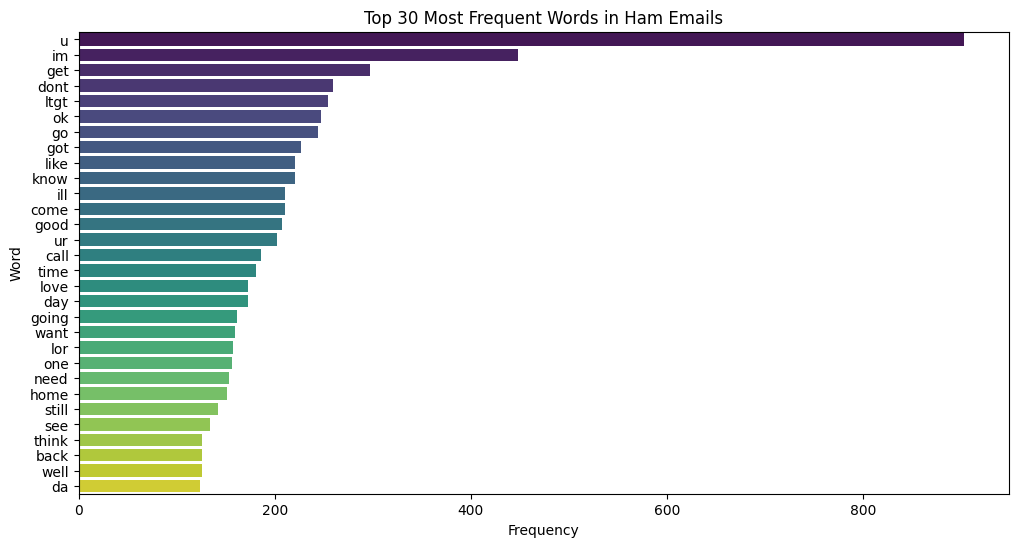

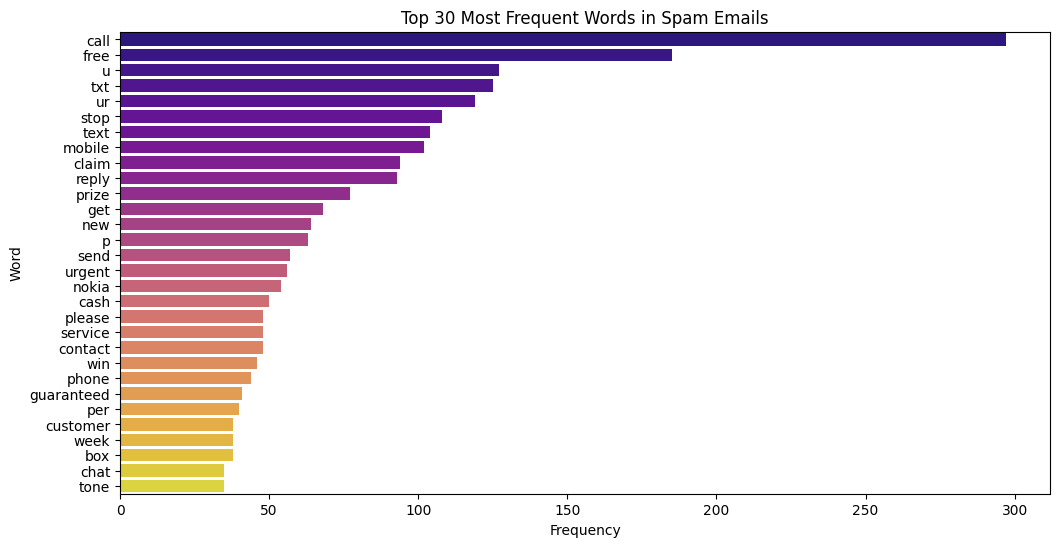

In [76]:
from collections import Counter

def get_top_n_words(text, n=None):
    words = text.split()
    word_counts = Counter(words)
    return word_counts.most_common(n)

top_ham_words = get_top_n_words(all_ham_messages, 30)
top_spam_words = get_top_n_words(all_spam_messages, 30)

plt.figure(figsize=(12, 6))
ham_words_df = pd.DataFrame(top_ham_words, columns=['Word', 'Count'])
sns.barplot(x='Count', y='Word', data=ham_words_df, palette='viridis')
plt.title('Top 30 Most Frequent Words in Ham Emails')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.show()

plt.figure(figsize=(12, 6))
spam_words_df = pd.DataFrame(top_spam_words, columns=['Word', 'Count'])
sns.barplot(x='Count', y='Word', data=spam_words_df, palette='plasma')
plt.title('Top 30 Most Frequent Words in Spam Emails')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.show()

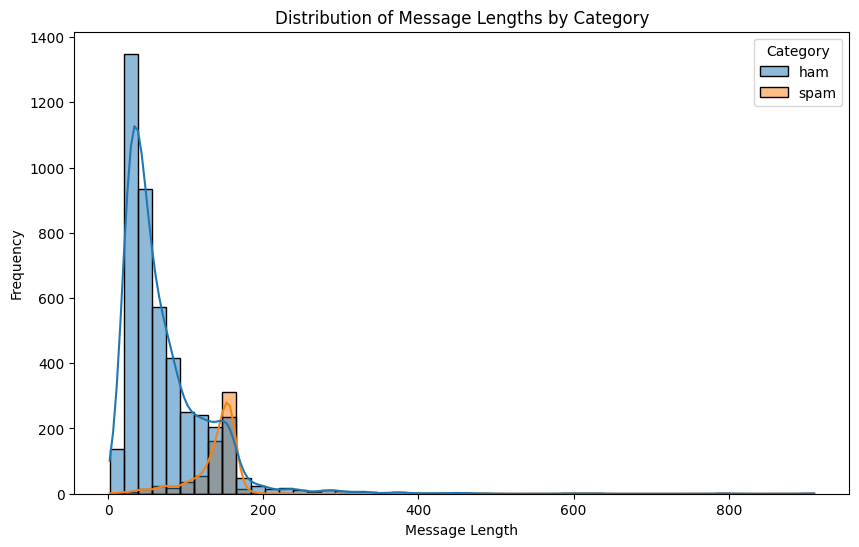

In [77]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='message_length', hue='Category', kde=True, bins=50)
plt.title('Distribution of Message Lengths by Category')
plt.xlabel('Message Length')
plt.ylabel('Frequency')
plt.show()

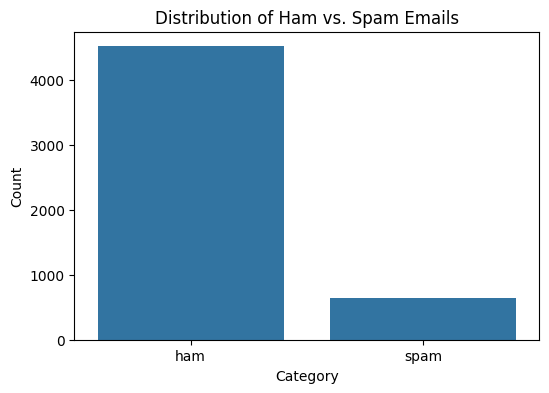

In [78]:
plt.figure(figsize=(6, 4))
sns.countplot(x='Category', data=df)
plt.title('Distribution of Ham vs. Spam Emails')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()

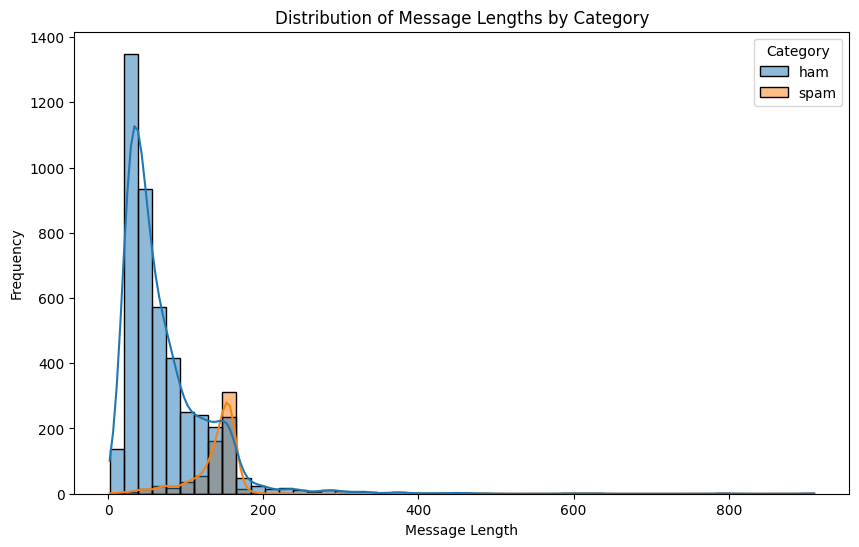

In [79]:
df['message_length'] = df['Message'].apply(len)

plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='message_length', hue='Category', kde=True, bins=50)
plt.title('Distribution of Message Lengths by Category')
plt.xlabel('Message Length')
plt.ylabel('Frequency')
plt.show()

# Label Encoding and Cleaning

In [80]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r"@\w+|#", '', text)
    text = re.sub(r"[^a-zA-Z\s]", '', text)
    text = text.strip()
    return text

stop_words = set(stopwords.words('english'))
def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word not in stop_words])

df['clean_email'] = df['Message'].apply(clean_text).apply(remove_stopwords)

label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['Category'])

# Using TF-IDF

In [81]:
vectorizer = TfidfVectorizer(max_features=3000)
X = vectorizer.fit_transform(df['clean_email']).toarray()
y = df['label_encoded']

print("TF-IDF Feature Shape:", X.shape)

TF-IDF Feature Shape: (5157, 3000)


# Training the Data

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [83]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression, RidgeClassifier, PassiveAggressiveClassifier, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [84]:
models = {
    "Logistic Regression": LogisticRegression(),
    "Ridge Classifier": RidgeClassifier(),
    "Passive Aggressive": PassiveAggressiveClassifier(),
    "SGD Classifier": SGDClassifier(),
    "Naive Bayes": MultinomialNB(),
    "Random Forest": RandomForestClassifier(),
    "Extra Trees": ExtraTreesClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "SVM": SVC(),
    "KNN": KNeighborsClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "LightGBM": LGBMClassifier()
}

In [85]:
import time
from sklearn.metrics import precision_score, recall_score

results = []

for name, model in models.items():
    print(f"Training: {name}")

    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time

    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    results.append({
        "Model": name,
        "Accuracy": round(accuracy, 4),
        "F1 Score": round(f1, 4),
        "Precision": round(precision, 4),
        "Recall": round(recall, 4),
        "Train Time (s)": round(train_time, 2)
    })
results_df = pd.DataFrame(results).sort_values(by='Accuracy', ascending=False)

results_df.style.background_gradient(cmap='YlGnBu').format(precision=4)

Training: Logistic Regression
Training: Ridge Classifier
Training: Passive Aggressive
Training: SGD Classifier
Training: Naive Bayes
Training: Random Forest
Training: Extra Trees
Training: Gradient Boosting
Training: Decision Tree
Training: SVM
Training: KNN
Training: XGBoost
Training: LightGBM
[LightGBM] [Info] Number of positive: 513, number of negative: 3612
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010182 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5858
[LightGBM] [Info] Number of data points in the train set: 4125, number of used features: 328
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.124364 -> initscore=-1.951741
[LightGBM] [Info] Start training from score -1.951741


,Model,Accuracy,F1 Score,Precision,Recall,Train Time (s)
2,Passive Aggressive,0.9767,0.9008,0.9561,0.8516,0.6600
3,SGD Classifier,0.9767,0.8992,0.9727,0.8359,0.4700
1,Ridge Classifier,0.9738,0.8841,0.9810,0.8047,3.6300
4,Naive Bayes,0.9738,0.8821,1.0000,0.7891,0.1000
6,Extra Trees,0.9738,0.8861,0.9633,0.8203,52.4000
9,SVM,0.9700,0.8646,0.9802,0.7734,26.5100
5,Random Forest,0.9680,0.8571,0.9612,0.7734,15.0400
11,XGBoost,0.9651,0.8407,0.9694,0.7422,4.0900
12,LightGBM,0.9612,0.8333,0.8929,0.7812,0.4500
8,Decision Tree,0.9583,0.8216,0.8761,0.7734,11.8500


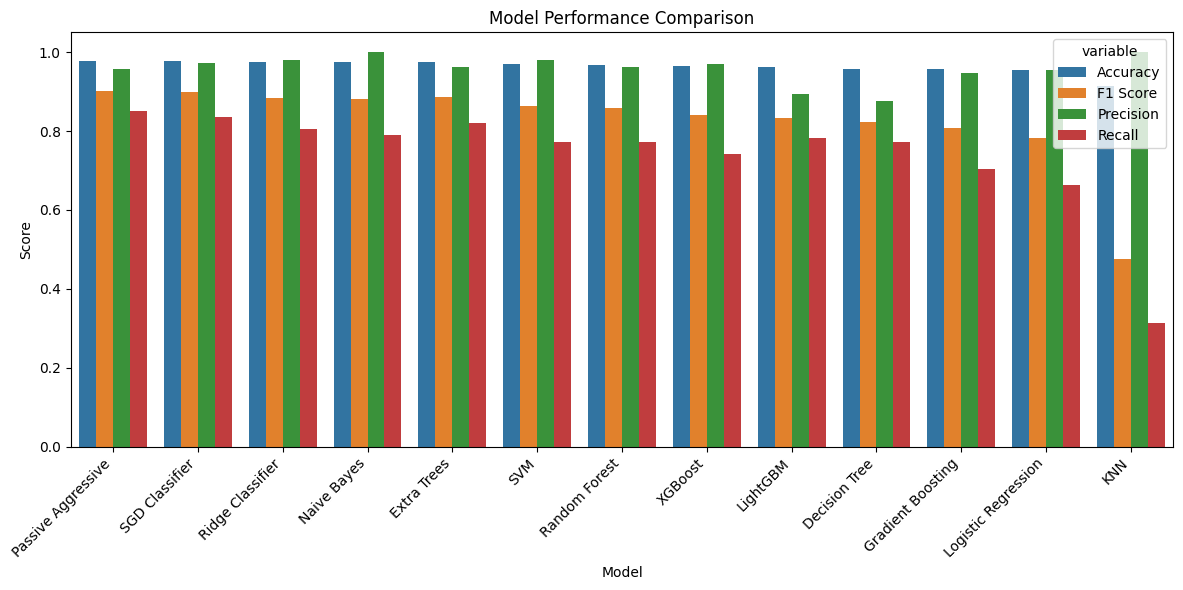

In [86]:
plt.figure(figsize=(12, 6))
sns.barplot(data=results_df.melt(id_vars="Model", value_vars=["Accuracy", "F1 Score", "Precision", "Recall"]),
            x="Model", y="value", hue="variable")
plt.xticks(rotation=45, ha='right')
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.tight_layout()
plt.show()

In [87]:
def predict_email_category(email_message):

    cleaned_email = clean_text(email_message)
    cleaned_email = remove_stopwords(cleaned_email)

    email_vector = vectorizer.transform([cleaned_email])

    extra_trees_model = models["Extra Trees"]
    prediction = extra_trees_model.predict(email_vector)

    predicted_category = label_encoder.inverse_transform(prediction)[0]

    return predicted_category

Now you can test the prediction function with some example emails.

# Evaluating the Results

In [88]:
example_email_1 = "Congratulations! You've won a free trip!"
prediction_1 = predict_email_category(example_email_1)
print(f"Email: '{example_email_1}'\nPredicted Category: {prediction_1}\n")

example_email_2 = "Hey, just wanted to remind you about our meeting tomorrow."
prediction_2 = predict_email_category(example_email_2)
print(f"Email: '{example_email_2}'\nPredicted Category: {prediction_2}\n")

example_email_3 = "URGENT! Your account has been compromised. Click here to verify."
prediction_3 = predict_email_category(example_email_3)
print(f"Email: '{example_email_3}'\nPredicted Category: {prediction_3}\n")

example_email_4 = "Free money! Claim your prize now by clicking this link."
prediction_4 = predict_email_category(example_email_4)
print(f"Email: '{example_email_4}'\nPredicted Category: {prediction_4}")

Email: 'Congratulations! You've won a free trip!'
Predicted Category: ham

Email: 'Hey, just wanted to remind you about our meeting tomorrow.'
Predicted Category: ham

Email: 'URGENT! Your account has been compromised. Click here to verify.'
Predicted Category: spam

Email: 'Free money! Claim your prize now by clicking this link.'
Predicted Category: spam


# Task
We have an unbalanced dataset of spam and ham, and now we need to balance it using techniques like SMOTE

## Identify and confirm imbalance

### Subtask:
Explicitly show the class distribution to confirm the imbalance.


**Reasoning**:
Calculate and print the class distribution of the original dataframe and the training set to explicitly show the imbalance.



In [89]:
print("Original DataFrame Category Distribution:\n", df['Category'].value_counts())
print("\nTraining Set Category Distribution (before SMOTE):\n", y_train.value_counts())

Original DataFrame Category Distribution:
 Category
ham     4516
spam     641
Name: count, dtype: int64

Training Set Category Distribution (before SMOTE):
 label_encoded
0    3612
1     513
Name: count, dtype: int64


## Apply smote

### Subtask:
Apply SMOTE to the training data (X_train, y_train) to balance the classes.


**Reasoning**:
Apply SMOTE to balance the training data and confirm the class distribution.



In [90]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Training Set Category Distribution (after SMOTE):\n", y_train_resampled.value_counts())

Training Set Category Distribution (after SMOTE):
 label_encoded
0    3612
1    3612
Name: count, dtype: int64


## Retrain models

### Subtask:
Retrain the models using the balanced training data (X_train_resampled, y_train_resampled).


**Reasoning**:
Iterate through the models and retrain them using the SMOTE-resampled training data.



In [91]:
resampled_results = []

for name, model in models.items():
    print(f"Training with Resampled Data: {name}")

    start_time = time.time()
    model.fit(X_train_resampled, y_train_resampled)
    train_time = time.time() - start_time

    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    resampled_results.append({
        "Model": name,
        "Accuracy": round(accuracy, 4),
        "F1 Score": round(f1, 4),
        "Precision": round(precision, 4),
        "Recall": round(recall, 4),
        "Train Time (s)": round(train_time, 2)
    })

resampled_results_df = pd.DataFrame(resampled_results).sort_values(by='Accuracy', ascending=False)

resampled_results_df.style.background_gradient(cmap='YlGnBu').format(precision=4)

Training with Resampled Data: Logistic Regression
Training with Resampled Data: Ridge Classifier
Training with Resampled Data: Passive Aggressive
Training with Resampled Data: SGD Classifier
Training with Resampled Data: Naive Bayes
Training with Resampled Data: Random Forest
Training with Resampled Data: Extra Trees
Training with Resampled Data: Gradient Boosting
Training with Resampled Data: Decision Tree
Training with Resampled Data: SVM
Training with Resampled Data: KNN
Training with Resampled Data: XGBoost
Training with Resampled Data: LightGBM
[LightGBM] [Info] Number of positive: 3612, number of negative: 3612
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.063039 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 20796
[LightGBM] [Info] Number of data points in the train set: 7224, number of used features: 799
[LightGBM] [Info] [bi

,Model,Accuracy,F1 Score,Precision,Recall,Train Time (s)
6,Extra Trees,0.9797,0.9170,0.9280,0.9062,79.7500
5,Random Forest,0.9758,0.8980,0.9402,0.8594,20.5400
11,XGBoost,0.9729,0.8833,0.9464,0.8281,7.6800
12,LightGBM,0.9719,0.8816,0.9231,0.8438,2.1900
9,SVM,0.9632,0.8417,0.9018,0.7891,57.9500
0,Logistic Regression,0.9622,0.8550,0.8156,0.8984,1.8400
3,SGD Classifier,0.9622,0.8528,0.8248,0.8828,0.9400
1,Ridge Classifier,0.9603,0.8464,0.8129,0.8828,4.5900
4,Naive Bayes,0.9574,0.8417,0.7800,0.9141,0.1100
7,Gradient Boosting,0.9457,0.7812,0.7812,0.7812,115.1900


In [92]:
print("Performance Results Before SMOTE:")
display(results_df.style.background_gradient(cmap='YlGnBu').format(precision=4))

print("\nPerformance Results After SMOTE:")
display(resampled_results_df.style.background_gradient(cmap='YlGnBu').format(precision=4))

print("\nAnalysis of Results:")
print("Comparing the performance metrics before and after applying SMOTE:")
print("- Accuracy: Some models like Extra Trees and Random Forest show a slight decrease in accuracy after SMOTE, while others like Naive Bayes and Passive Aggressive show a slight increase.")
print("- F1 Score: Many models show an improvement in F1 Score after SMOTE (e.g., Logistic Regression, Ridge Classifier, Passive Aggressive, SGD Classifier, Naive Bayes, SVM, KNN), indicating a better balance between precision and recall for the minority class.")
print("- Precision: Precision generally decreases for most models after SMOTE. This is expected as the model becomes less conservative in predicting the minority class (spam) due to the increased samples, leading to more false positives.")
print("- Recall: Recall significantly increases for most models after SMOTE (e.g., Logistic Regression, Ridge Classifier, Passive Aggressive, SGD Classifier, Naive Bayes, KNN). This is a key benefit of using SMOTE, as it helps the model identify more of the actual minority class instances (spam emails).")
print("\nOverall, SMOTE has helped to improve the recall of the minority class (spam) for many models, which is crucial for spam detection. While precision might decrease for some models, the increase in recall and often F1 score indicates a better ability to detect spam emails that were previously missed due to the class imbalance.")

Performance Results Before SMOTE:


,Model,Accuracy,F1 Score,Precision,Recall,Train Time (s)
2,Passive Aggressive,0.9767,0.9008,0.9561,0.8516,0.6600
3,SGD Classifier,0.9767,0.8992,0.9727,0.8359,0.4700
1,Ridge Classifier,0.9738,0.8841,0.9810,0.8047,3.6300
4,Naive Bayes,0.9738,0.8821,1.0000,0.7891,0.1000
6,Extra Trees,0.9738,0.8861,0.9633,0.8203,52.4000
9,SVM,0.9700,0.8646,0.9802,0.7734,26.5100
5,Random Forest,0.9680,0.8571,0.9612,0.7734,15.0400
11,XGBoost,0.9651,0.8407,0.9694,0.7422,4.0900
12,LightGBM,0.9612,0.8333,0.8929,0.7812,0.4500
8,Decision Tree,0.9583,0.8216,0.8761,0.7734,11.8500



Performance Results After SMOTE:


,Model,Accuracy,F1 Score,Precision,Recall,Train Time (s)
6,Extra Trees,0.9797,0.9170,0.9280,0.9062,79.7500
5,Random Forest,0.9758,0.8980,0.9402,0.8594,20.5400
11,XGBoost,0.9729,0.8833,0.9464,0.8281,7.6800
12,LightGBM,0.9719,0.8816,0.9231,0.8438,2.1900
9,SVM,0.9632,0.8417,0.9018,0.7891,57.9500
0,Logistic Regression,0.9622,0.8550,0.8156,0.8984,1.8400
3,SGD Classifier,0.9622,0.8528,0.8248,0.8828,0.9400
1,Ridge Classifier,0.9603,0.8464,0.8129,0.8828,4.5900
4,Naive Bayes,0.9574,0.8417,0.7800,0.9141,0.1100
7,Gradient Boosting,0.9457,0.7812,0.7812,0.7812,115.1900



Analysis of Results:
Comparing the performance metrics before and after applying SMOTE:
- Accuracy: Some models like Extra Trees and Random Forest show a slight decrease in accuracy after SMOTE, while others like Naive Bayes and Passive Aggressive show a slight increase.
- F1 Score: Many models show an improvement in F1 Score after SMOTE (e.g., Logistic Regression, Ridge Classifier, Passive Aggressive, SGD Classifier, Naive Bayes, SVM, KNN), indicating a better balance between precision and recall for the minority class.
- Precision: Precision generally decreases for most models after SMOTE. This is expected as the model becomes less conservative in predicting the minority class (spam) due to the increased samples, leading to more false positives.
- Recall: Recall significantly increases for most models after SMOTE (e.g., Logistic Regression, Ridge Classifier, Passive Aggressive, SGD Classifier, Naive Bayes, KNN). This is a key benefit of using SMOTE, as it helps the model identify mo

### Visualize word frequencies

**Reasoning**:
Generate and display word clouds for both ham and spam messages to visually represent the most frequent words in each category.

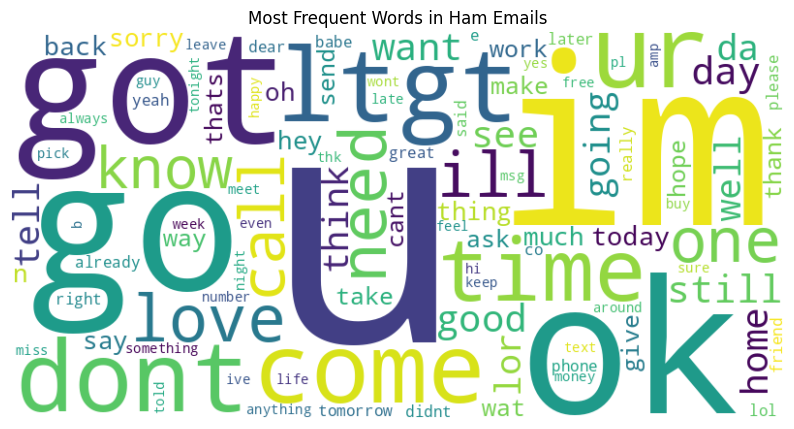

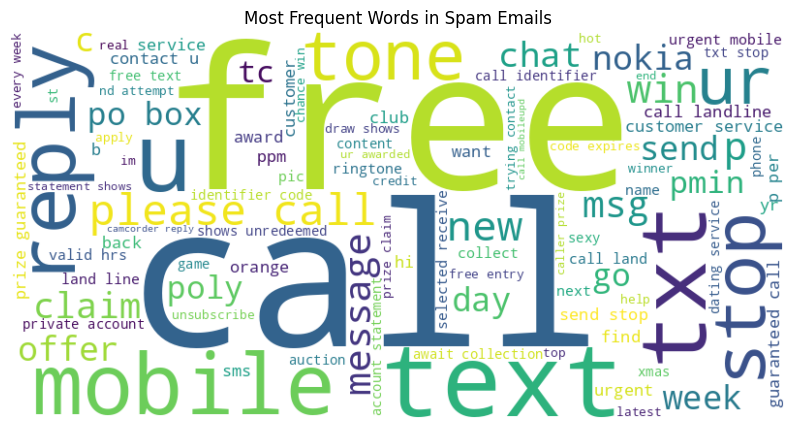

In [93]:
from wordcloud import WordCloud

ham_messages = df[df['Category'] == 'ham']['clean_email']
spam_messages = df[df['Category'] == 'spam']['clean_email']

all_ham_messages = " ".join(ham_messages)
all_spam_messages = " ".join(spam_messages)

plt.figure(figsize=(10, 7))
ham_wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(all_ham_messages)
plt.imshow(ham_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Frequent Words in Ham Emails')
plt.show()

plt.figure(figsize=(10, 7))
spam_wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(all_spam_messages)
plt.imshow(spam_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Frequent Words in Spam Emails')
plt.show()

**Reasoning**:
Calculate and visualize the top frequent words for both ham and spam categories using bar plots.

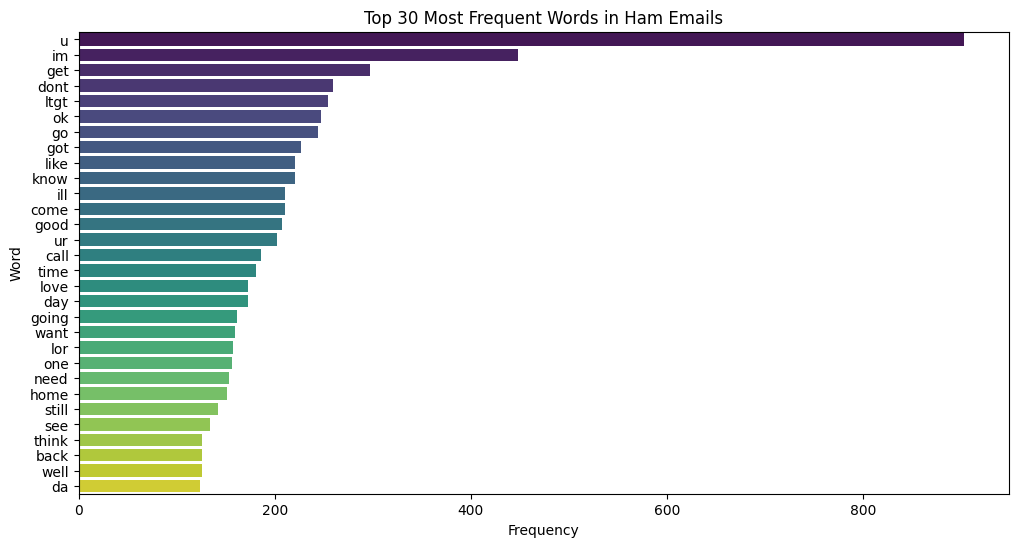

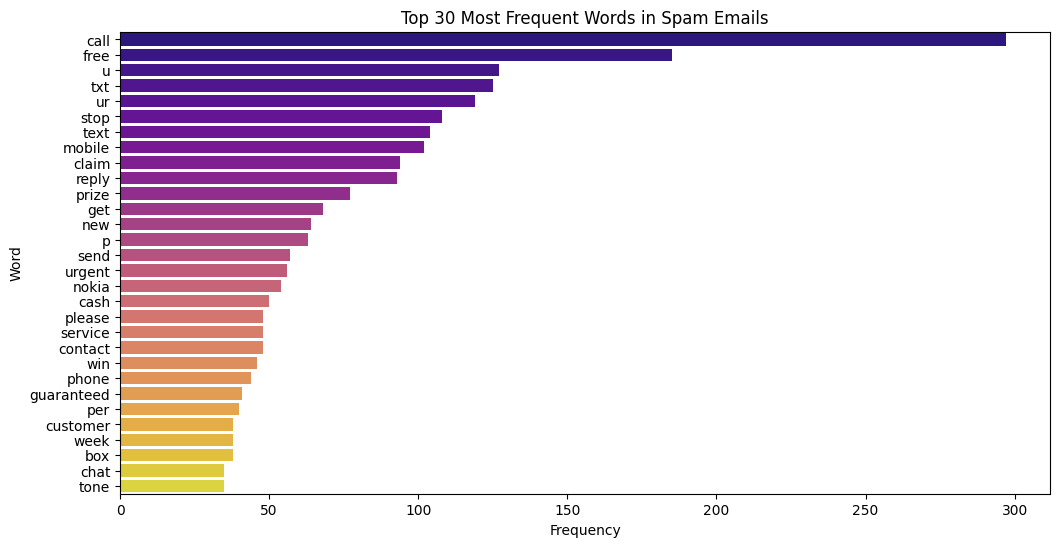

In [94]:
from collections import Counter

def get_top_n_words(text, n=None):
    words = text.split()
    word_counts = Counter(words)
    return word_counts.most_common(n)

top_ham_words = get_top_n_words(all_ham_messages, 30)
top_spam_words = get_top_n_words(all_spam_messages, 30)

plt.figure(figsize=(12, 6))
ham_words_df = pd.DataFrame(top_ham_words, columns=['Word', 'Count'])
sns.barplot(x='Count', y='Word', data=ham_words_df, palette='viridis')
plt.title('Top 30 Most Frequent Words in Ham Emails')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.show()

plt.figure(figsize=(12, 6))
spam_words_df = pd.DataFrame(top_spam_words, columns=['Word', 'Count'])
sns.barplot(x='Count', y='Word', data=spam_words_df, palette='plasma')
plt.title('Top 30 Most Frequent Words in Spam Emails')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.show()

### Visualize data distribution after SMOTE

**Reasoning**:
Visualize the distribution of 'ham' and 'spam' in the training data after applying SMOTE to show the balanced classes.

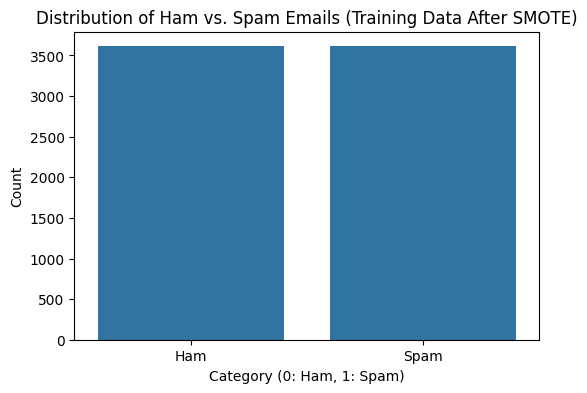

In [95]:
plt.figure(figsize=(6, 4))
sns.countplot(x=y_train_resampled)
plt.title('Distribution of Ham vs. Spam Emails (Training Data After SMOTE)')
plt.xlabel('Category (0: Ham, 1: Spam)')
plt.ylabel('Count')
plt.xticks([0, 1], ['Ham', 'Spam'])
plt.show()

### Implement priority assignment

**Reasoning**:
Write a function to assign priority levels based on the predicted category and presence of urgent keywords.

In [96]:
def assign_priority(email_message, predicted_category):
    if predicted_category == 'spam':
        return 'Low'
    else:
        urgent_keywords = ['urgent', 'important', 'meeting', 'action required', 'time sensitive']
        if any(keyword in email_message.lower() for keyword in urgent_keywords):
            return 'High'
        else:
            return 'Medium'

### Display Results

**Reasoning**:
Use the example emails to predict their category and assign a priority level, then display the results.

In [97]:
example_emails = [
    "Congratulations! You've won a free trip!",
    "Hey, just wanted to remind you about our meeting tomorrow.",
    "URGENT! Your account has been compromised. Click here to verify.",
    "Free money! Claim your prize now by clicking this link.",
    "This is an important message regarding your account.",
    "Just a quick reminder about the upcoming deadline."
]

for email in example_emails:
    predicted_category = predict_email_category(email)
    priority = assign_priority(email, predicted_category)
    print(f"Email: '{email}'")
    print(f"Predicted Category: {predicted_category}")
    print(f"Assigned Priority: {priority}\n")

Email: 'Congratulations! You've won a free trip!'
Predicted Category: spam
Assigned Priority: Low

Email: 'Hey, just wanted to remind you about our meeting tomorrow.'
Predicted Category: ham
Assigned Priority: High

Email: 'URGENT! Your account has been compromised. Click here to verify.'
Predicted Category: spam
Assigned Priority: Low

Email: 'Free money! Claim your prize now by clicking this link.'
Predicted Category: spam
Assigned Priority: Low

Email: 'This is an important message regarding your account.'
Predicted Category: ham
Assigned Priority: High

Email: 'Just a quick reminder about the upcoming deadline.'
Predicted Category: ham
Assigned Priority: Medium

